# Abalore Rings Prediction Model

In [340]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from IPython.display import clear_output, display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Dataset Analysis

In [341]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('./input/playground-series-s4e4/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))
# Display the first 5 examples
dataset_df.head(5)

Full train dataset shape is (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [342]:
print(len(dataset_df['Rings'].unique()))
dataset_df['Rings'].unique()

28


array([11,  6, 10,  9,  4,  8, 15,  7, 12, 20, 17, 13, 14,  5, 23,  3, 22,
       16, 18, 19, 21, 25,  1, 29,  2, 27, 24, 26])

### NAN checks

Thankfully no null values.

In [343]:
dataset_df.isnull().sum().sort_values(ascending=False)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [344]:
dataset_df.describe(include='all')

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,33093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,45307.000000,NaN,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,NaN,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,NaN,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,NaN,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,NaN,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000


In [345]:
print("Sex:")
print(dataset_df.Sex.describe())
print(dataset_df.Sex.unique())

Sex:
count     90615
unique        3
top           I
freq      33093
Name: Sex, dtype: object
['F' 'I' 'M']


### Gender Analysis

There seems to be some correlation between the size of the Abalone's and its gender. This makes sense since infants are usually smaller than the adults.

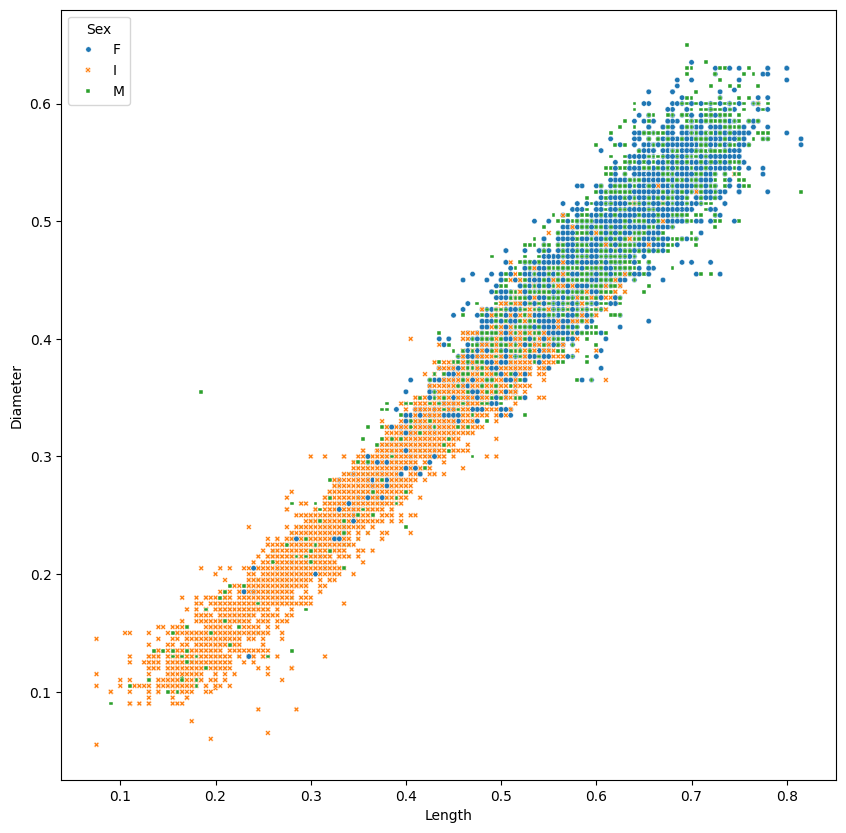

In [346]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.scatterplot(data=dataset_df, x='Length', y='Diameter', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()

Infants tend to have smaller rings, whereas the distribution of number of rings for males and females seem to be similar. This suggests that the number of rings is mostly determined by size than anything else. We could potentially just distinguish infants from adults.

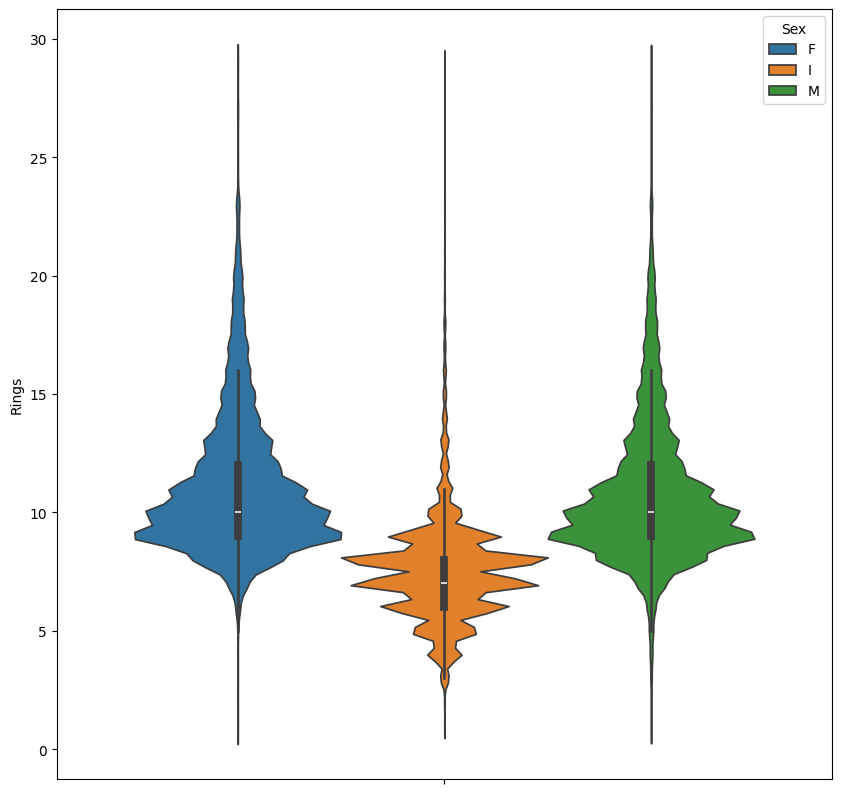

In [347]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.violinplot(data=dataset_df, hue='Sex', y='Rings', ax=ax)
plt.show()

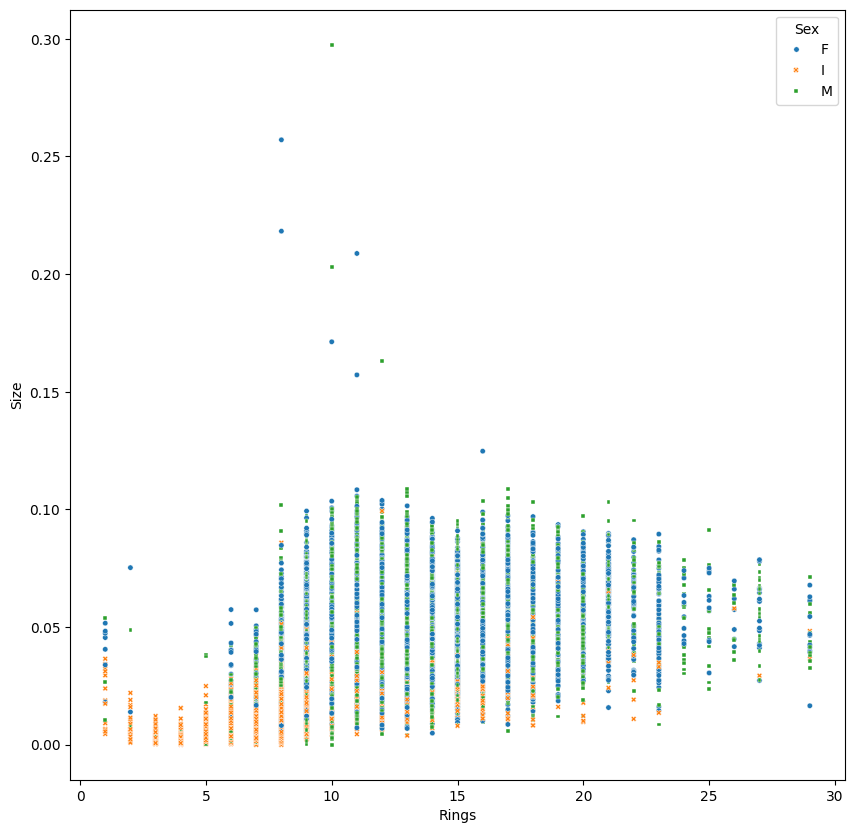

In [348]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

size_df = dataset_df
size_df['Size'] = dataset_df['Length'] * dataset_df['Diameter'] * dataset_df['Height']
sns.scatterplot(data=size_df, x='Rings', y='Size', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()
# size_df.drop(columns=['Size'], inplace=True)

### Weight Analysis

Apparently `Whole weight.1` and `Whole weight.2` mean `Shucked Weight` and `Viscera Weight`, according to https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488073. For my own convenience, I'm renaming these columns. It seems that the sum of the weights `shucked` and `shell`, or the total weight of the Abalone post shucking, should be strictly less than the `weight_whole`.

In [349]:
dataset_df['weight_whole'] = dataset_df['Whole weight']
dataset_df['weight_shucked'] = dataset_df['Whole weight.1']
dataset_df['weight_viscera'] = dataset_df['Whole weight.2']
dataset_df['weight_shell'] = dataset_df['Shell weight']
dataset_df.drop(columns=['Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight'], inplace=True)

There are roughly 296 entries where the sum of the post-shucking weights are greater than the whole weight, which is unlikely. One abalone almost a third of its own weight.

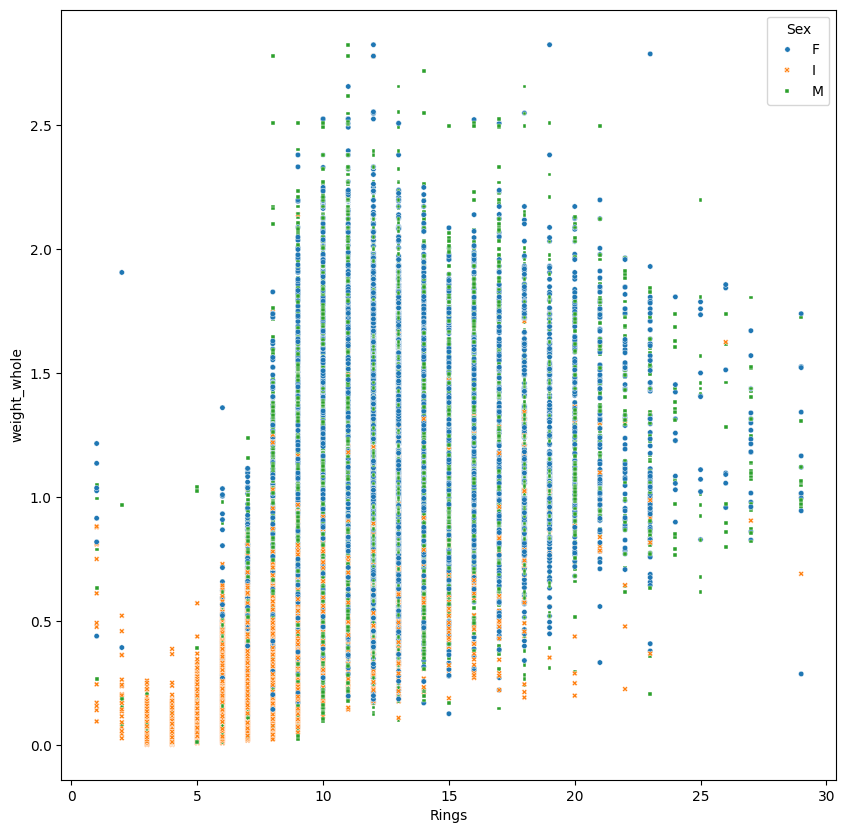

In [350]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.scatterplot(data=dataset_df, x='Rings', y='weight_whole', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()

In [351]:
w_cols = ['weight_shucked', 'weight_shell']
dataset_df['weight_sum'] = dataset_df[w_cols].sum(axis=1)
print((dataset_df['weight_sum'] <= dataset_df['weight_whole']).value_counts())
print()
print(f"mean: {((dataset_df['weight_whole'] - dataset_df['weight_sum']) > 0).mean()}")
print(f"std: {((dataset_df['weight_whole'] - dataset_df['weight_sum']) > 0).std()}")
print()
weight_outliers = dataset_df.loc[(dataset_df['weight_sum'] > dataset_df['weight_whole'])]
print(weight_outliers.id.count())
print(f"mean: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).mean()}")
print(f"std: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).std()}")
print(f"max: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).max()}")
print(f"min: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).min()}")
print()
# abalone that gained 0.4595g after being shucked had a whole weight of 1.218g
odd_id = (weight_outliers['weight_sum'] - weight_outliers['weight_whole']).argmax()
dataset_df['weight_whole'][odd_id]

True     90319
False      296
dtype: int64

mean: 0.9965347900457981
std: 0.058764278121165886

296
mean: 0.04483614864864865
std: 0.10479788947301452
max: 0.4595
min: 3.469446951953614e-18



1.218

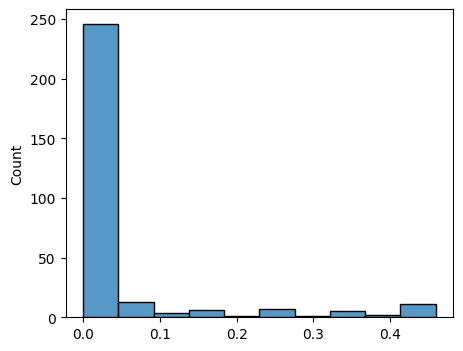

In [352]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

sns.histplot(data=(weight_outliers['weight_sum'] - weight_outliers['weight_whole']), bins=10, ax=ax)
plt.show()

For now, we'll simply drop the outliers. Maybe later we could include the outliers whose difference between `weight_shucked + weight_shell` and `weight_whole` is negligible.

In [353]:
dataset_df.drop(dataset_df.loc[dataset_df['weight_sum'] > dataset_df['weight_whole']].index, inplace=True)

We can see that no abalones have `weight_shucked`, `weight_shell`, or `weight_viscera` greater than `weight_whole`.

In [354]:
print((dataset_df['weight_shucked'] < dataset_df['weight_whole']).value_counts())
print((dataset_df['weight_shell'] < dataset_df['weight_whole']).value_counts())
print((dataset_df['weight_viscera'] < dataset_df['weight_whole']).value_counts())

True    90319
dtype: int64
True    90319
dtype: int64
True    90319
dtype: int64


### Heigh, Diameter, Length

We'll also drop the few abalones with height 0.

In [355]:
dataset_df.loc[(dataset_df['Height'] == 0)].count()

id                4
Sex               4
Length            4
Diameter          4
Height            4
Rings             4
Size              4
weight_whole      4
weight_shucked    4
weight_viscera    4
weight_shell      4
weight_sum        4
dtype: int64

In [356]:
dataset_df.drop(dataset_df.loc[(dataset_df['Height'] == 0)].index, inplace=True)

### Feature Correlation

We can observe high correlation between all numerical features, which is expected. Don't think there's much point to applying pca here though, considering we have only 7 input features to work with.

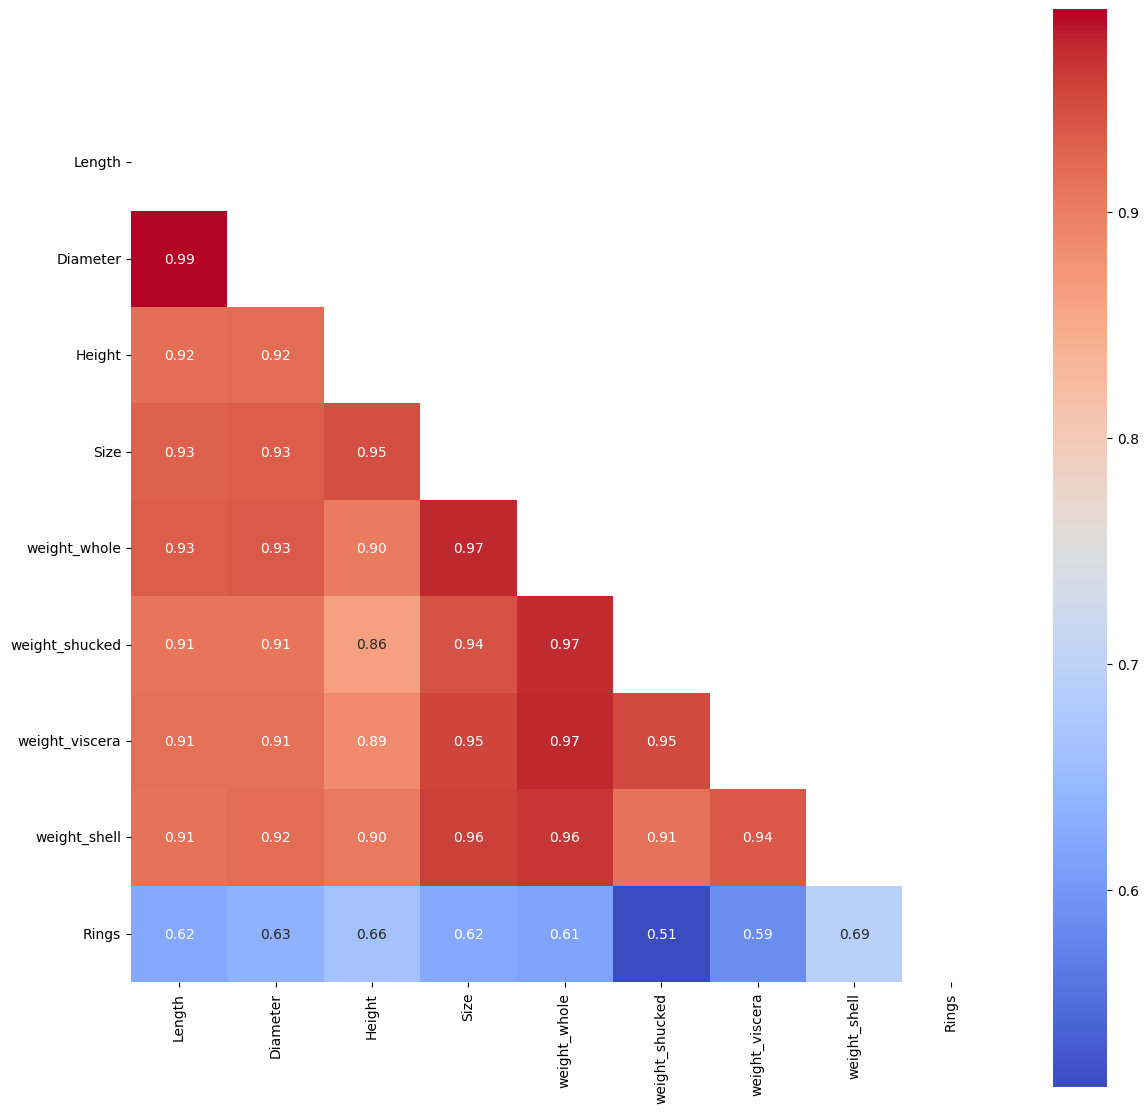

In [357]:
# reorganizing columns
dataset_df = dataset_df[[col for col in dataset_df.columns if col != 'Rings'] + ['Rings']]

corr = dataset_df.drop(columns=['Sex', 'id', 'weight_sum']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", square=True, cmap='coolwarm')
plt.show()

### Training

In [362]:
X = dataset_df.drop(columns=['Rings', 'Sex', 'id'])
y = dataset_df['Rings']
y = y
# X['sex_M'] = (dataset_df['Sex'] == 'M').astype(float)
# X['sex_F'] = (dataset_df['Sex'] == 'F').astype(float)
# X['sex_I'] = (dataset_df['Sex'] == 'I').astype(float)
def sex_to_int(x):
  if x == 'M':
    return 0
  elif x == 'F':
    return 1
  else:
    return 2
X['sex'] = dataset_df['Sex'].astype("category") # .apply(sex_to_int)
X.head()

,Length,Diameter,Height,Size,weight_whole,weight_shucked,weight_viscera,weight_shell,weight_sum,sex
0,0.550,0.430,0.150,0.035475,0.7715,0.3285,0.1465,0.2400,0.5685,F
1,0.630,0.490,0.145,0.044761,1.1300,0.4580,0.2765,0.3200,0.7780,F
2,0.160,0.110,0.025,0.000440,0.0210,0.0055,0.0030,0.0050,0.0105,I
3,0.595,0.475,0.150,0.042394,0.9145,0.3755,0.2055,0.2500,0.6255,M
4,0.555,0.425,0.130,0.030664,0.7820,0.3695,0.1600,0.1975,0.5670,I


In [363]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

## Deep Learning Regression Model

Define Model and Trainer class.

Performance-wise no difference between the MLP only model and the gender embedding model. Maybe I need to implement a different loss function? Train the embedding first and then train the MLP.

## XGBoost Regression

In [364]:
xgb_model = XGBRegressor(n_estimators = 5000, learning_rate = 0.01, random_state = 42, enable_categorical=True, objective='reg:squarederror', eval_metric='rmse', early_stopping_rounds = 10)
xgb_model.fit(X_train, y_train.apply(lambda y_i: np.log(y_i + 1)), eval_set = [(X_test, y_test.apply(lambda y_i: np.log(y_i + 1)))])

[0]	validation_0-rmse:0.28219
[1]	validation_0-rmse:0.28027
[2]	validation_0-rmse:0.27837
[3]	validation_0-rmse:0.27650
[4]	validation_0-rmse:0.27465
[5]	validation_0-rmse:0.27283
[6]	validation_0-rmse:0.27103
[7]	validation_0-rmse:0.26926
[8]	validation_0-rmse:0.26750
[9]	validation_0-rmse:0.26578
[10]	validation_0-rmse:0.26407
[11]	validation_0-rmse:0.26239
[12]	validation_0-rmse:0.26073
[13]	validation_0-rmse:0.25910
[14]	validation_0-rmse:0.25749
[15]	validation_0-rmse:0.25590
[16]	validation_0-rmse:0.25433
[17]	validation_0-rmse:0.25278
[18]	validation_0-rmse:0.25126
[19]	validation_0-rmse:0.24975
[20]	validation_0-rmse:0.24826
[21]	validation_0-rmse:0.24679
[22]	validation_0-rmse:0.24534
[23]	validation_0-rmse:0.24391
[24]	validation_0-rmse:0.24250
[25]	validation_0-rmse:0.24111
[26]	validation_0-rmse:0.23974
[27]	validation_0-rmse:0.23838
[28]	validation_0-rmse:0.23705
[29]	validation_0-rmse:0.23572
[30]	validation_0-rmse:0.23440
[31]	validation_0-rmse:0.23312
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Classification Model

Instead of predicitng the number of Rings, we assign a given Abalone to one of the observed 28 Ring classifications. First we have to adjust the targets so that they are within the range of 0 to 27.

## XGBoost Classifier

In [374]:
def adjust_target(y):
    if y < 28:
        return y - 1
    else:
        return y - 2

xgb_model = XGBClassifier(n_estimators = 5000, learning_rate = 0.03, verbosity = 1, random_state = 42, enable_categorical=True, objective='reg:logistic', early_stopping_rounds = 10)
xgb_model.fit(X_train, y_train.apply(adjust_target), eval_set = [(X_test, y_test.apply(adjust_target))])

[0]	validation_0-mlogloss:3.24207
[1]	validation_0-mlogloss:3.16424
[2]	validation_0-mlogloss:3.09554
[3]	validation_0-mlogloss:3.03397
[4]	validation_0-mlogloss:2.97820
[5]	validation_0-mlogloss:2.92726
[6]	validation_0-mlogloss:2.88022
[7]	validation_0-mlogloss:2.83663
[8]	validation_0-mlogloss:2.79584
[9]	validation_0-mlogloss:2.75768
[10]	validation_0-mlogloss:2.72191
[11]	validation_0-mlogloss:2.68825
[12]	validation_0-mlogloss:2.65643
[13]	validation_0-mlogloss:2.62621
[14]	validation_0-mlogloss:2.59748
[15]	validation_0-mlogloss:2.57029
[16]	validation_0-mlogloss:2.54443
[17]	validation_0-mlogloss:2.51978
[18]	validation_0-mlogloss:2.49629
[19]	validation_0-mlogloss:2.47377
[20]	validation_0-mlogloss:2.45238
[21]	validation_0-mlogloss:2.43167
[22]	validation_0-mlogloss:2.41179
[23]	validation_0-mlogloss:2.39272
[24]	validation_0-mlogloss:2.37442
[25]	validation_0-mlogloss:2.35674
[26]	validation_0-mlogloss:2.33984
[27]	validation_0-mlogloss:2.32347
[28]	validation_0-mlogloss:2.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Sex -> Maturity

In [369]:
X = dataset_df.drop(columns=['weight_sum', 'Rings', 'Sex', 'id', 'Length'])
y = dataset_df['Rings']
# X['sex_M'] = (dataset_df['Sex'] == 'M').astype(float)
# X['sex_F'] = (dataset_df['Sex'] == 'F').astype(float)
# X['sex_I'] = (dataset_df['Sex'] == 'I').astype(float)
def sex_to_int(x):
  if x == 'I':
    return 0
  else:
    return 1
X['maturity'] = dataset_df['Sex'].apply(sex_to_int).astype('category')

In [370]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

## XGBoost Regressor with Maturity category

In [371]:
xgb_model = XGBRegressor(n_estimators = 5000, learning_rate = 0.03, random_state = 42, enable_categorical=True, objective='reg:squarederror', eval_metric='rmse', early_stopping_rounds = 100)
xgb_model.fit(X_train, y_train.apply(lambda y_i: np.log(y_i + 1)), eval_set = [(X_test, y_test.apply(lambda y_i: np.log(y_i + 1)))])

[0]	validation_0-rmse:0.27832
[1]	validation_0-rmse:0.27272
[2]	validation_0-rmse:0.26734
[3]	validation_0-rmse:0.26218
[4]	validation_0-rmse:0.25724
[5]	validation_0-rmse:0.25249
[6]	validation_0-rmse:0.24792
[7]	validation_0-rmse:0.24357
[8]	validation_0-rmse:0.23936
[9]	validation_0-rmse:0.23534
[10]	validation_0-rmse:0.23144
[11]	validation_0-rmse:0.22774
[12]	validation_0-rmse:0.22420
[13]	validation_0-rmse:0.22076
[14]	validation_0-rmse:0.21755
[15]	validation_0-rmse:0.21441
[16]	validation_0-rmse:0.21145
[17]	validation_0-rmse:0.20860
[18]	validation_0-rmse:0.20592
[19]	validation_0-rmse:0.20332
[20]	validation_0-rmse:0.20083
[21]	validation_0-rmse:0.19847
[22]	validation_0-rmse:0.19618
[23]	validation_0-rmse:0.19402
[24]	validation_0-rmse:0.19197
[25]	validation_0-rmse:0.19000
[26]	validation_0-rmse:0.18813
[27]	validation_0-rmse:0.18636
[28]	validation_0-rmse:0.18466
[29]	validation_0-rmse:0.18305
[30]	validation_0-rmse:0.18152
[31]	validation_0-rmse:0.18006
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Submission

Test output to confirm that the rmsle calculation is correct.

In [ ]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
test_df.head(5)

In [ ]:
test_X_df = test_df.drop(columns=['Sex', 'id'])
def sex_to_int(x):
  if x == 'M':
    return 0
  elif x == 'F':
    return 1
  else:
    return 2
test_X_df['sex'] = test_df['Sex'].apply(sex_to_int)
test_X_df.head()

In [ ]:
test_X = torch.Tensor(test_X_df.values)
test_X_inputs, test_X_genders = torch.split(test_X, [7,1], dim=1)
model.eval()
with torch.no_grad():
  test_y_hat = model(test_X_inputs, test_X_genders.squeeze().long()).squeeze()
submission['Rings'] = test_y_hat

In [ ]:
submission.to_csv("submission.csv", index = False)